### **THANK YOU FOR THE RECOMMENDATION**

**Recommendation Systems**

**Massachusetts institute of Technology**
**and Great Learning**

By Jeffandy St.Hubert

August 24, 2024


--------------
## **Table of contents:**
--------------
- Business Problem
- Objective
- Data overview
- User-user similarity model
- Item-Item similarity model
- Exploratory Data analysis
- matrix factorization model
- rank based model
- conclusion & recommendations

----------------
## **Business Problem:**
----------------

The rate, variety, and sheer amount of information is growing exponentially in e-commerce. This poses unique challenges but not without unique opportunities.

In fact, this increase in data allows for the most personalized customer experience in modern history. If Amazon can be at the edge of recommendation system innovation through ranking, collaborative filtering, and matrix factorization-based algorithms, the unanimous response from each customer will be “Thanks for the recommendation” and Amazon will continue to lead in the e-commerce space.

----------------
## **Objective:**
----------------

I am a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. I have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating.

#personal notes

*different types of rank based systems*

* creating a rank based recommendation system
* similarity-based collaborative filtering
* matrix factorization based collaborative filtering
* clustering based recommendation system

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, I have used **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357289 sha256=6919552b20d91e8249f25263a02dfb9371659366b7a6f63b433a3e7996d51bdf
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [1]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**

In [ ]:
# Import the dataset
df = pd.read_csv('/content/drive/MyDrive/AllTogether_Solutions_Inc/Python_Drive/ratings_Electronics.csv', header = None) # There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, I can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

#the ~ means not. so we are removing the users less than 5
df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Printing a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [ ]:
# Checking the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  65290
No of columns:  3


### **Data types**

In [ ]:
# Checking Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**OBSERVATIONS:** there are no null values. ratings are a number value and others are object and may be strings

### **Checking for missing values**

In [ ]:
# Checking for missing values present and provide observations
# user item interation matrix pivoting the data
# each business on the column each user on the row

missing_values = df_final.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
user_id    0
prod_id    0
rating     0
dtype: int64


**DATA OBSERVATIONS:**

The average rating is 4.3 which is pretty high.

Bar plot shows it is left-skewed with most items rated 5/5

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating'
df_final['rating'].describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### **Checking the rating distribution**

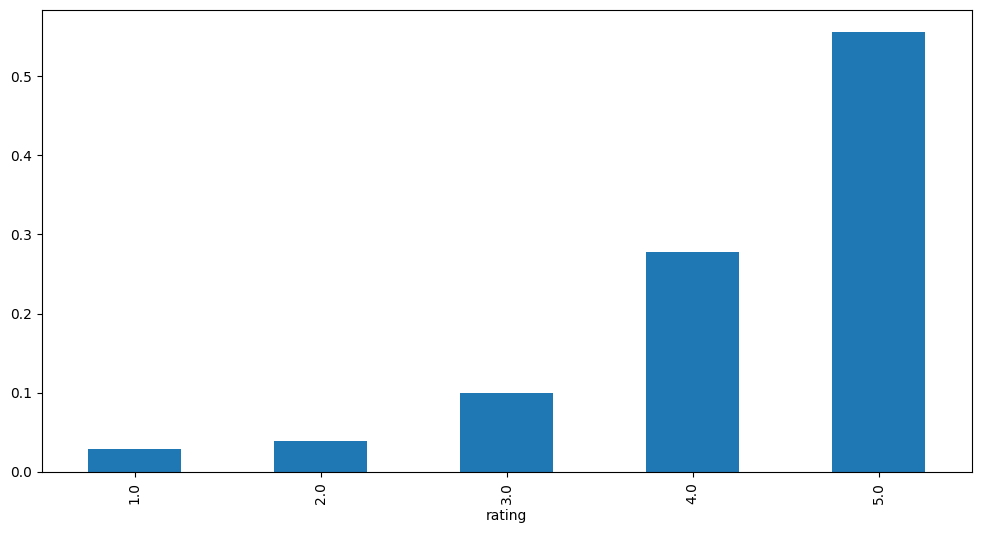

In [ ]:
# bar plot
plt.figure(figsize = (12, 6))

df_final['rating'].value_counts(1).sort_values(ascending=True).plot(kind='bar')

plt.show()

**OBSERVATIONS:**

The average rating is 4.3 which is pretty high.

Bar plot shows it is left-skewed with most items rated 5/5

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data

print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

The number of observations in the final data =  65290
Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


**OBSERVATIONS:**

there are 1540 x 5689 possible outcomes for our user-item matrix

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

,0
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A22CW0ZHY3NJH8,193
A1UQBFCERIP7VJ,193
AWPODHOB4GFWL,184


- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


### Steps:

- **Create the final_rating DataFrame**
- **Create the function top_n_products**
- **Recommending top 5 products with 50 minimum interactions based on popularity**
- **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating': average_rating, 'count_rating': count_rating})

# Sort the dataframe by average of ratings in descending order
final_rating = final_rating.sort_values('average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head(15)

,average_rating,count_rating
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8
B003CK10DG,5.0,5
B003B41XYO,5.0,5
B0007WK8KS,5.0,6
B0084FM5JC,5.0,5


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['count_rating'] >= min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values('average_rating', ascending=False)

    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
# Recommending top 5 products with 100 minimum interactions based on popularity
top_5_products_100_interactions = top_n_products(final_rating, n=5, min_interaction=100)

# Display the top 5 products
print("Top 5 products with at least 100 interactions based on popularity:")
print(top_5_products_100_interactions)

Top 5 products with at least 100 interactions based on popularity:
Index(['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE'], dtype='object', name='prod_id')


### **Recommending top 5 products with 100 minimum interactions based on popularity**

1. 'B003ES5ZUU'
2. 'B000N99BBC'
3. 'B002WE6D44'
4. 'B007WTAJTO'
5. 'B002V88HFE']


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example -
<ol>
    <li><b>Ratings</b> provided by users. For example, ratings of books on goodread, movie ratings on imdb, etc.</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos.</li>
    <li><b>Use/buying</b> of a product by users. For example, buying different items on e-commerce sites.</li>
    <li><b>Reading</b> of articles by readers on various blogs.</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user. (KNN based algorithim)
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

HYPER PARAMETERS
* the way we calculate the distance between users or items (euclidean or cosine similarity etc.)
* with 10,000 plus users there are many similar users. the amount of similar users we take into account is a hyper parameter

SURPRISE LIBTRARY
* we are using KNN. KNN referes to K nearest neighbors. For user B which all users are closest to use B
--- this is the equation used by KNN which is iterated over the data

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**PERSONAL NOTES: basic terminologies I am using:**

**Relevant item:** An item (product in this case) that is actually *rated higher than the threshold rating* is relevant, if the *actual rating is below the threshold then it is a non-relevant item*.  

**Recommended item:** An item that's *predicted rating is higher than the threshold is a recommended item*, if the *predicted rating is below the threshold then that product will not be recommended to the user*.  


**False Negative (FN):** It is the *frequency of relevant items that are not recommended to the user*. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the *loss of opportunity for the service provider*, which they would like to minimize!!!

**False Positive (FP):** It is the *frequency of recommended items that are actually not relevant*. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in *loss of resources for the service provider*, which they would also like to minimize. #MEDIUMFACTS

**Recall:** It is the *fraction of actually relevant items that are recommended to the user*, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the *fraction of recommended items that are relevant actually*, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### *PERFORMANCE METRICS* **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- I will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, testset, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

# Declare the similarity options
sim_options = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options provided, verbose=False, and setting random_state=1
sim_user_user = KNNBasic(sim_options = sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Compute precision@k, recall@k, and F1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user, testset=testset, k=10, threshold=3.5)


RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**PERSONAL NOTES:**

- To compute **precision and recall**, a *threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings*.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

- **first I will Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1**

- **then fit the model on the training data**

- **then use the precision_recall_at_k function to calculate the metrics on the test data**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options provided, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user, testset=testset, k=10, threshold=3.5)


RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5 which is denoted by the parameter r_ui.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
df_final[df_final.prod_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

**OBSERVATIONS:**

It can be observed from the above list that user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466" as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

### **Improving Similarity-based Recommendation System by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9721159376789178
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized, testset=testset, k=10, threshold=3.5)


RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


### **Steps:**
- **I will Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **then predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Finally I will compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", r_ui = 5, verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

### **Identifying similar Users to a given User (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**.

Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item, testset=testset)

#why does this keep failing unless I add testset=testset, k=10, threshold=3.5

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`**. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**OBSERVATIONS:**

* The actual rating (r_ui) of 5.00 is the real score that the user A3LDPF5FMB782Z gave to the product 1400501466.

* The estimated rating (est) of 4.27 is the score that the model predicts based on similar users or items.

* The { 'actual_k': 22, 'was_impossible': False } part indicates that the prediction was made using 22 similar items, and it was possible to make a prediction (was_impossible: False).

* The model predicted that the user would likely rate the product around 4.27, which is close to the actual rating of 5.00. This suggests that the model's prediction is reasonably accurate but slightly underestimates the user's actual preference for this product.

* The model used information from 22 similar items to make this prediction, meaning it relied on items that are similar to 1400501466 to estimate how the user would rate it.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", r_ui = 5, verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**OBSERVATIONS:**


* The estimated rating (est) of 4.29 is what the model predicts the user might give to the product 1400501466. However, this prediction might not be accurate because the model is indicating that there weren't enough similar items or users to make a reliable prediction.

* The was_impossible: True flag suggests that the model couldn't find enough similar users or items to base this prediction on. Because of this, the model might have had to make a guess, and this guess might not be reliable.

* The reason 'Not enough neighbors' confirms that the model couldn't find enough similar items (neighbors) that the user has interacted with to confidently predict a rating for this particular product


**KEY TAKEAWAY**
The model tried to predict a rating but couldn't do so reliably because it didn't have enough data about similar products that the user has interacted with. The prediction of 4.29 is an attempt, but the model itself is signaling that this estimate might not be trustworthy due to insufficient data.

### **Hyperparameter tuning the item-item similarity-based model**

- Use the following values for the param_grid and tune the model
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9749208880072092
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized, testset=testset)

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**OBSERVATIONS:**

comparing the performance metrics of the tuned model with those of the non-tuned model:

1. RMSE (Root Mean Squared Error):
Non-Tuned Model: 0.9950
Tuned Model: 0.9576
Contrast: The tuned model has a lower RMSE compared to the non-tuned model. This improvement (from 0.9950 to 0.9576) indicates that the tuned model makes more accurate predictions, with the predicted ratings being closer to the actual ratings.

2. Precision:
Non-Tuned Model: 0.838
Tuned Model: 0.839
Contrast: There is a slight improvement in precision from 0.838 to 0.839. This suggests that both models are quite good at recommending relevant items, but the tuned model is marginally better at avoiding irrelevant recommendations.

3. Recall:
Non-Tuned Model: 0.845
Tuned Model: 0.88
Contrast: The recall improved significantly from 0.845 to 0.88 after tuning. This indicates that the tuned model is much better at capturing a larger proportion of relevant items, meaning it can recommend a broader set of items that users are likely to be interested in.

4. F1 Score:
Non-Tuned Model: 0.841
Tuned Model: 0.859
Contrast: The F1 score, which balances precision and recall, increased from 0.841 to 0.859. This improvement reflects that the tuned model not only recommends relevant items but also does so with a better balance between precision and recall, leading to overall better performance.
Summary of Contrast:
RMSE Improvement: The lower RMSE in the tuned model shows it provides more accurate predictions.
Precision Consistency: Precision remained almost the same, showing that both models are effective in avoiding irrelevant recommendations.
Recall Improvement: The tuned model is much better at identifying and recommending relevant items, as shown by the significant increase in recall.
Better Overall Performance (F1 Score): The improved F1 score in the tuned model indicates that it achieves a better balance between recommending the right items and ensuring most relevant items are included.

### **Steps:**
- **First I will predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Then predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Finally I will compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**OBSERVATIONS:**

Let's compare the prediction results from the optimized model with those from the baseline model for the two users: one who has interacted with the product and one who has not.

1. User "A3LDPF5FMB782Z" with Product "1400501466" (Interacted Product)
Optimized Model Output:

Actual Rating (r_ui): 5.00
Estimated Rating (est): 4.67
Details: {'actual_k': 22, 'was_impossible': False}
Baseline Model Output: (Based on the previous context)

Actual Rating (r_ui): 5.00
Estimated Rating (est): 4.27
Details: {'actual_k': 22, 'was_impossible': False}
Comparison:

Estimated Rating: The optimized model predicts a higher rating (4.67) compared to the baseline model (4.27). This suggests that the optimized model has better captured the user’s preferences, leading to a more accurate prediction closer to the actual rating of 5.
Actual Neighbors (actual_k): Both models used 22 neighbors to make the prediction, indicating that they both had enough similar items to make a reliable prediction.
2. User "A34BZM6S9L7QI4" with Product "1400501466" (Non-Interacted Product)
Optimized Model Output:

Actual Rating (r_ui): None (The user hasn't rated this product before)
Estimated Rating (est): 4.29
Details: {'was_impossible': True, 'reason': 'Not enough neighbors.'}
Baseline Model Output: (Based on the previous context)

Actual Rating (r_ui): None
Estimated Rating (est): 4.29
Details: {'was_impossible': True, 'reason': 'Not enough neighbors.'}

**Comparison:**

* Estimated Rating: Both models predict an identical estimated rating of 4.29 for the non-interacted product. This indicates that the optimization didn’t significantly affect the prediction for this particular case where the user had no prior interaction with the product.

* "Was Impossible" Reason: Both models flagged the prediction as "impossible" due to not having enough neighbors ('reason': 'Not enough neighbors.'). This suggests that for users who haven't interacted with the product, the models struggle to make confident predictions, and this remains a challenge even after optimization.

**Summary:**
* Interacted Product (User A3LDPF5FMB782Z): The optimized model provided a more accurate prediction closer to the actual rating compared to the baseline model, reflecting an improvement in model performance after tuning.

* Non-Interacted Product (User A34BZM6S9L7QI4): There was no noticeable difference between the baseline and optimized models, as both struggled due to insufficient neighbors. The challenge of predicting ratings for users with no prior interaction with a product remains even after optimization.

***The optimized model performs better for users with a history of interaction, but its effectiveness is still limited for users with no prior interaction data.***

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 3: Matrix Factorization**

Matrix-Factorization Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
!pip install matplotlib-venn

In [ ]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy

# Converting data into a Surprise Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=1)

# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Predicting ratings for the test set
predictions = svd.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)

# Calculate precision@k, recall@k, and F1-Score
from surprise.model_selection import precision_recall_at_k

precision_recall_results = precision_recall_at_k(predictions, k=5, threshold=3.5)
precision = precision_recall_results['precision']
recall = precision_recall_results['recall']
f1 = precision_recall_results['f1']

print(f"RMSE: {rmse}")
print(f"Precision@5: {precision}")
print(f"Recall@5: {recall}")
print(f"F1-Score@5: {f1}")

RMSE: 0.9126


ImportError: cannot import name 'precision_recall_at_k' from 'surprise.model_selection' (/usr/local/lib/python3.10/dist-packages/surprise/model_selection/__init__.py)

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.06   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0636214055362645, details={'was_impossible': False})

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.06   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.062013995343408, details={'was_impossible': False})

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8993868709014311
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state = 1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized, testset=testset)

RMSE: 0.9037
Precision:  0.846
Recall:  0.841
F_1 score:  0.843


**OBSERVATIONS:**

RMSE: 0.9037

* This value is relatively low, indicating that the model's predictions are close to the actual ratings. The lower the RMSE, the better the model's accuracy.
Precision: 0.846

* This high precision indicates that a large proportion of the top-k items recommended by the model are relevant to the users.

Recall: 0.841

* A recall close to precision suggests that the model is good at capturing a significant portion of the relevant items that should be recommended.

F1-Score: 0.843

* The F1-score being close to both precision and recall shows a good balance between these two metrics, meaning the model is effective at recommending relevant items while capturing a large number of them.



### **Conclusions:**

in conclusion, I created three types of models: a rank-based model, a collaborative filtering item-item based model and a matrix factorization model


Accuracy (RMSE): The optimized SVD model performs better with a lower RMSE, indicating more accurate predictions.

Precision and Recall: The optimized SVD model has slightly higher precision, while the item-to-item model has higher recall.

F1 Score: The item-to-item model has a better F1 score, suggesting a more effective balance between precision and recall.


### **Recommendations:**

If accuracy is the primary goal and making precise predictions is crucial, the optimized SVD model is better.

If recall and ensuring that a higher proportion of relevant items are recommended is more important, the item-to-item model might be preferred.


**Given the balance of precision and recall, the item-to-item model has a better F1 score, making it a more balanced recommendation system overall. However, since the SVD model has the best precision and prediction accuracy this is ideal for Amazon. Giving a precice recommendation coupled with the truth "it is easier to sell to one who is already buying" makes this a surefire way to please the customer and increase Amazon’s bottom line while making the company a go-to place to find what you didn't know you needed.**